In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import gurobi_logtools as glt

In [2]:
method_list = ['FICA', 'CVAR']
eps_theta_pair_list = [(0.03, 2.5e-1), (0.03, 1.3e-1), (0.06, 4.2e-1), (0.06, 2.1e-1)]
gurobi_seed_list = [i for i in range(0, 10000*10, 10000)] 
num_gen_list = [38]  # the number of thermal generators
N_WDR_list = [80]  # the number of scenarios for the WDRJCC
load_scaling_factor_list = [1]  # [1] the scaling factor for the load
T_list = [12, 14, 16, 18, 20]
network_name = 'case24_ieee_rts' 
Fgap = 0.001 # 0.1%, the same as the MIP gap
bigM = 1e5
thread=4
timelimit = 3600

In [3]:
# reload the module to have updated functions
param_comb = list(itertools.product(load_scaling_factor_list, eps_theta_pair_list, T_list, num_gen_list, N_WDR_list))

save_path_root = os.path.join(os.getcwd(), f'PD_results_bigM{int(bigM)}_thread{thread}')

def convert(n):
    # return the original number if it is not None nor nan, otherwise return nan
    if (n is None) or (np.isnan(n)):
        return np.nan
    else:
        return n

def n_nonan(n):
    # return the number of non-nan in the list
    return sum([1 for i in n if not np.isnan(i)])

def mynanmean(n):
    # if all nan, return nan; otherwise, return the nanmean
    return np.nan if all(np.isnan(i) for i in n) else np.nanmean(n)

def sortedmean(n, first_k):
    return mynanmean(np.sort(n)[:first_k])


def load_results(param_comb, save_path_root):
    # save the result for each random run
    res_all_df = []
    for param in param_comb:
        # load the parameters. N_WDR is the number of historical samples of random variables for the WDRJCC
        load_scaling_factor, (epsilon, theta), T, num_gen, N_WDR = param
        # note, all time results are in seconds
        min_cost_dict = {method: [] for method in method_list} # cost of the proposed solution
        status_dict = {method: [] for method in method_list} # optimization status of the proposed method

        break_flag = False
        
        for gurobi_seed in gurobi_seed_list:
            for method in method_list:
                # the path to the result
                res_save_path = os.path.join(save_path_root, f'result_{network_name}_theta{theta}_epsilon{epsilon}_gurobi_seed{gurobi_seed}_num_gen{num_gen}_N_WDR{N_WDR}_load_scaling_factor{load_scaling_factor}_{method}_T{T}.npy')
                log_save_path = os.path.join(save_path_root, f'{network_name}_theta{theta}_epsilon{epsilon}_gurobi_seed{gurobi_seed}_num_gen{num_gen}_N_WDR{N_WDR}_load_scaling_factor{load_scaling_factor}_{method}_T{T}.txt')

                # the following IF statement enables you to see the results over the running process (no need to wait until the end of the whole process)
                if not os.path.exists(res_save_path) or not os.path.exists(log_save_path):
                    break_flag = True
                    break

                res = np.load(res_save_path, allow_pickle=True).item()
                try:
                    status = glt.parse(log_save_path).summary().Status.item() # the optimization status of the proposed method
                except Exception as e:
                    sol_count = glt.parse(log_save_path).summary().SolCount.item() # the number of solutions found
                    if sol_count > 0:
                        status = 'subOPTIMAL'
                    else:
                        print(glt.parse(log_save_path).summary().columns)
                        raise ValueError(f"Failed to retrieve status from log file: {log_save_path}. Error: {e}")
                
                min_cost = res['min_cost (USD)']
                reliability = res['reliability_test (%)']
                time = res['t_solve (s)']

                if np.isnan(convert(time)):
                    # As explained in the paper, we set the time to the timelimit if no feasible solution is found
                    time = timelimit

                # append results to lists
                min_cost_dict[method].append(convert(min_cost))
                status_dict[method].append(status)

                res_all_df.append(pd.DataFrame({
                    'eps': epsilon, 
                    'theta': theta, 
                    'T': T,
                    'load_scaling_factor': load_scaling_factor,
                    'num_gen': num_gen, 
                    'N_WDR': N_WDR, 
                    'method': method,
                    'Time': time,
                    'min_cost': min_cost,
                    'reliability': reliability,
                    'seed': gurobi_seed,
                    'status': status
                }, index=[0]))
        #     if break_flag:
        #         break
        # if break_flag:
        #     break
            
    res_all_df = pd.concat(res_all_df, ignore_index=True)
    return res_all_df

res_all_df = load_results(param_comb, save_path_root)
# display all rows
pd.set_option('display.max_rows', 10)
res_all_df

,eps,theta,T,load_scaling_factor,num_gen,N_WDR,method,Time,min_cost,reliability,seed,status
0,0.03,0.25,12,1,38,80,FICA,2.381704,284970.497221,99.20,0,OPTIMAL
1,0.03,0.25,12,1,38,80,CVAR,86.178977,284970.497208,99.20,0,OPTIMAL
2,0.03,0.25,12,1,38,80,FICA,2.266529,323150.311730,97.22,10000,OPTIMAL
3,0.03,0.25,12,1,38,80,CVAR,86.644511,323150.311721,97.22,10000,OPTIMAL
4,0.03,0.25,12,1,38,80,FICA,2.397197,272392.537954,98.12,20000,OPTIMAL
...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.06,0.21,20,1,38,80,CVAR,2078.675573,432857.886044,86.02,70000,OPTIMAL
396,0.06,0.21,20,1,38,80,FICA,6.458828,455540.065661,87.60,80000,OPTIMAL
397,0.06,0.21,20,1,38,80,CVAR,2116.064053,455540.065649,87.60,80000,OPTIMAL
398,0.06,0.21,20,1,38,80,FICA,6.396632,440288.807680,83.20,90000,OPTIMAL


In [4]:
res_all_df[(res_all_df['T']>=16)]

,eps,theta,T,load_scaling_factor,num_gen,N_WDR,method,Time,min_cost,reliability,seed,status
40,0.03,0.25,16,1,38,80,FICA,3.281040,410400.163985,96.44,0,OPTIMAL
41,0.03,0.25,16,1,38,80,CVAR,1994.450467,410400.164346,96.44,0,OPTIMAL
42,0.03,0.25,16,1,38,80,FICA,3.267400,386209.959802,96.84,10000,OPTIMAL
43,0.03,0.25,16,1,38,80,CVAR,1890.452440,386209.959799,96.84,10000,OPTIMAL
44,0.03,0.25,16,1,38,80,FICA,3.390621,350475.963125,97.88,20000,OPTIMAL
...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.06,0.21,20,1,38,80,CVAR,2078.675573,432857.886044,86.02,70000,OPTIMAL
396,0.06,0.21,20,1,38,80,FICA,6.458828,455540.065661,87.60,80000,OPTIMAL
397,0.06,0.21,20,1,38,80,CVAR,2116.064053,455540.065649,87.60,80000,OPTIMAL
398,0.06,0.21,20,1,38,80,FICA,6.396632,440288.807680,83.20,90000,OPTIMAL


In [5]:
res_all_df['status'].unique()

array(['OPTIMAL'], dtype=object)

We can see that the proportion of "Time Limit" runs of "proposed" (the proposed SFLA) is lower than "exact" (ExactS), which demonstrates the efficiency of the proposed method.

# Plotting the results

In [6]:
# configure the plotting
import seaborn as sns
import matplotlib.pyplot as plt
# set plotting options, font size, and style to Academic theme (Times New Roman, etc.)
# Set matplotlib style
plt.style.use('default')
plt.rcParams.update({
    'font.size': 13,
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'legend.fontsize': 13,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    "mathtext.fontset": "cm",
})

# Plot the proposed time vs exact time F

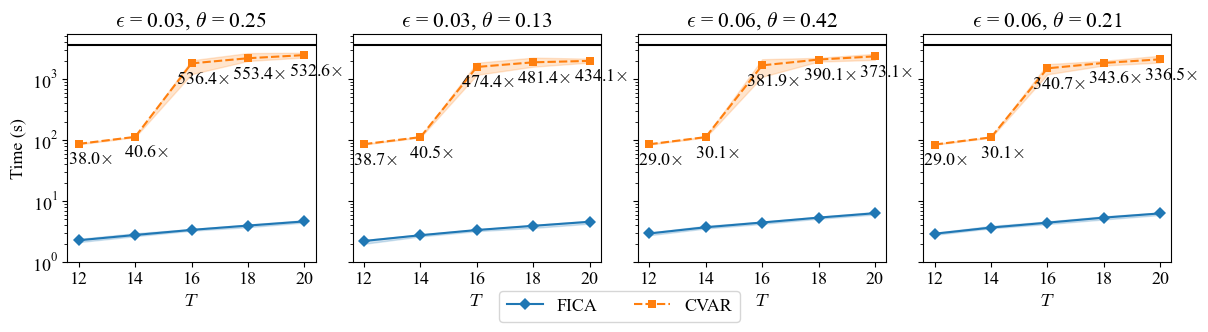

In [7]:
# the x-axis is the T

num_gen = 38
N_WDR = 80
T_list_plot = T_list
markers = ['D', 's']  # Different markers for each line
TimeF = False

eps_theta_pair_list_plot = eps_theta_pair_list

num_seed = 150
seed_threshold = gurobi_seed_list[:num_seed][-1]+1 # +1 to include the last seed (avoid numerical error)

fig, axs = plt.subplots(1, len(eps_theta_pair_list_plot), figsize=(3*len(eps_theta_pair_list_plot), 3.3), sharey=True)
for i, (eps, theta) in enumerate(eps_theta_pair_list_plot):
    res_all_df_plot = res_all_df[(res_all_df['eps'] == eps) & (res_all_df['theta'] == theta) & (res_all_df['num_gen'] == num_gen)  & (res_all_df['N_WDR'] == N_WDR) & (res_all_df['seed']<=seed_threshold) & (res_all_df['T'].isin(T_list_plot))].copy()
    ax = axs[i]
    sns.lineplot(x='T', y='Time_F' if TimeF else 'Time', data=res_all_df_plot, ax=ax, 
             hue='method', estimator='mean', errorbar=('pi', 99), style='method', markers=markers, n_boot=1000, markersize=6, markeredgewidth=0)
    # plot a horizontal line at timelimit
    ax.axhline(timelimit, color='black', linestyle='-')
    ax.set_title(fr'$\epsilon$ = {eps}, $\theta$ = {theta}')
    # set xticks
    ax.set_xticks(T_list_plot)
    # set x axis
    ax.set_xlabel('$T$')
    ax.set_ylabel('TimeF (s)' if TimeF else 'Time (s)')
    # remove y label if i > 0
    if i > 0:
        ax.set_ylabel('')
    # log y scale
    ax.set_yscale('log')
    # set ylim
    ax.set_ylim(1, timelimit*1.5)
    # do not display the legend
    ax.get_legend().remove()
    # calculate the mean time for each method and display the speedup rate (compared to FICA) as text on the plot
    mean_time_FICA = res_all_df_plot[res_all_df_plot['method'] == 'FICA']['Time_F' if TimeF else 'Time'].groupby(res_all_df_plot['T']).mean()
    mean_time_CVAR = res_all_df_plot[res_all_df_plot['method'] == 'CVAR']['Time_F' if TimeF else 'Time'].groupby(res_all_df_plot['T']).mean()
    speedup_rate = mean_time_CVAR / mean_time_FICA
    # plot the speedup rate below the curve for CVAR
    for j, T in enumerate(T_list_plot):
        ax.text(T+.4, mean_time_CVAR.iloc[j]*0.4, rf'{speedup_rate.iloc[j]:.1f}$\times$', ha='center', va='bottom', fontsize=13)

# create my own legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, .14), ncol=2)
plt.subplots_adjust(top=0.89, bottom=0.2, left=0.06, right=0.98, hspace=0, wspace=0.15)
# save the figure
path_name = os.path.join(os.path.dirname(save_path_root), 'figure', f'PD_time_{network_name}_Fgap{Fgap}_allT_N{N_WDR}.pdf')
if not os.path.exists(os.path.dirname(path_name)):
    os.makedirs(os.path.dirname(path_name))
plt.savefig(path_name)

In [8]:
# calculate the difference in min_cost between FICA and CVAR, by matching all other columns
FICA_df = res_all_df[res_all_df['method'] == 'FICA'].copy()
CVAR_df = res_all_df[res_all_df['method'] == 'CVAR'].copy()
# merge the two dataframes on all columns except 'min_cost'
merged_df = pd.merge(FICA_df, CVAR_df, on=['eps', 'theta', 'T', 'num_gen', 'N_WDR', 'seed'], suffixes=('_FICA', '_CVAR'))
# calculate the difference in min_cost
merged_df['min_cost_diff %'] = (merged_df['min_cost_CVAR'] - merged_df['min_cost_FICA']) / merged_df['min_cost_CVAR'] * 100  # in percentage
# display the statistics of min_cost_diff % over seeds, for each of the parameter combination
stats_df = merged_df.groupby(['eps', 'theta', 'T', 'num_gen', 'N_WDR']).agg({
    'min_cost_diff %': ['mean', 'std', 'min', 'max']
}).reset_index()
stats_df

eps theta   T num_gen N_WDR min_cost_diff %                              \
                                            mean           std           min   
0   0.03  0.13  12      38    80    1.219155e-08  2.408757e-08 -1.971825e-10   
1   0.03  0.13  14      38    80    9.686432e-09  1.249258e-08 -2.321131e-09   
2   0.03  0.13  16      38    80    1.949786e-08  2.617989e-08 -4.333747e-09   
3   0.03  0.13  18      38    80    9.931494e-09  1.403806e-08 -4.096292e-09   
4   0.03  0.13  20      38    80    1.867678e-08  2.529323e-08  2.287071e-10   
..   ...   ...  ..     ...   ...             ...           ...           ...   
15  0.06  0.42  12      38    80    1.771763e-08  2.909273e-08 -6.080358e-09   
16  0.06  0.42  14      38    80    2.653397e-08  4.042345e-08 -2.413049e-10   
17  0.06  0.42  16      38    80    2.043118e-08  3.274587e-08 -3.397668e-09   
18  0.06  0.42  18      38    80    1.693638e-08  3.418007e-08 -7.921706e-09   
19  0.06  0.42  20      38    80    1.818500e-08  2.690046e-08 -7.659262e-09   

                  
             max  
0   7.892639e-08  
1   3.764566e-08  
2   6.926096e-08  
3   3.516059e-08  
4   7.948270e-08  
..           ...  
15  8.291737e-08  
16  1.299203e-07  
17  9.888181e-08  
18  9.556420e-08  
19  6.836350e-08  

[20 rows x 9 columns]

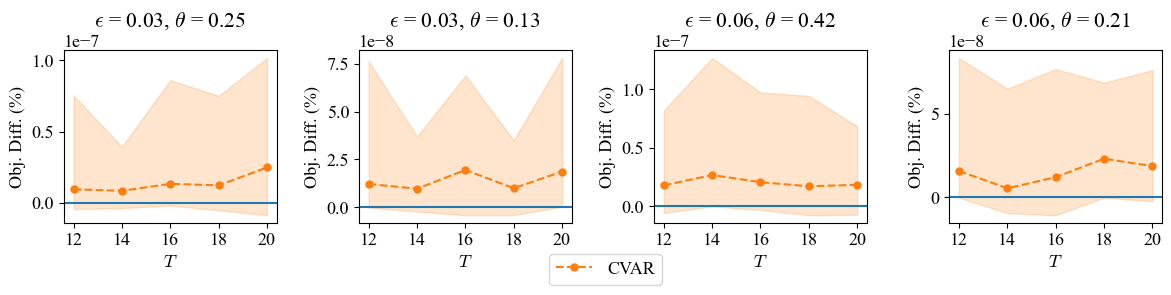

In [9]:

# the second color of tab:10
color = sns.color_palette("tab10")[1]

num_gen = num_gen_list[0]  # use the first num_gen from the list
N_WDR = N_WDR_list[0]  # use the first N_WDR from the list
T_list_plot = T_list
markers = ['o', 's']  # Different markers for each line
TimeF = True

num_seed = 150
seed_threshold = gurobi_seed_list[:num_seed][-1]+1

fig, axs = plt.subplots(1, len(eps_theta_pair_list_plot), figsize=(3*len(eps_theta_pair_list_plot), 3))

for i, (eps, theta) in enumerate(eps_theta_pair_list_plot):
    res_all_df_plot = merged_df[(merged_df['eps'] == eps) & (merged_df['theta'] == theta) & (merged_df['num_gen'] == num_gen)  & (merged_df['N_WDR'] == N_WDR) & (merged_df['seed']<=seed_threshold) & (merged_df['T'].isin(T_list_plot))].copy()
    ax = axs[i]
    sns.lineplot(x='T', y='min_cost_diff %', data=res_all_df_plot, ax=ax, 
         estimator='mean', errorbar=('pi', 99), markers=markers, n_boot=1000, markersize=6, markeredgewidth=0, color=color, marker = 'o', linestyle='--')
    ax.axhline(0, color=sns.color_palette("tab10")[0], linestyle='-')

    ax.set_title(fr'$\epsilon$ = {eps}, $\theta$ = {theta}')
    # set xticks
    ax.set_xticks(T_list_plot)
    # set x axis
    ax.set_xlabel('$T$')
    ax.set_ylabel('Obj. Diff. (%)')

# create my own legend for CVAR
custom_lines = [plt.Line2D([0], [0], color=color, marker='o', linestyle='--', markersize=6, markeredgewidth=0)]
fig.legend(custom_lines, ['CVAR'], loc='upper center', bbox_to_anchor=(0.52, .15), ncol=2)
plt.tight_layout()
# plt.subplots_adjust(top=0.87)
# save the figure
path_name = os.path.join(os.path.dirname(save_path_root), 'figure', f'PD_gap_{network_name}_Fgap{Fgap}_allT_N{N_WDR}.pdf')
if not os.path.exists(os.path.dirname(path_name)):
    os.makedirs(os.path.dirname(path_name))
plt.savefig(path_name)

## Plot sensi on prop of gens

In [10]:
method_list = ['FICA', 'CVAR']
eps_theta_pair_list = [(0.03, 1.3e-1), (0.06, 2.1e-1)]
gurobi_seed_list = [i for i in range(0, 10000*10, 10000)] 
num_gen_list = [13, 26, 38]  # the number of thermal generators
N_WDR_list = [80]  # the number of scenarios for the WDRJCC
num_branch = 38
load_scaling_factor_list = [1]  # [1] the scaling factor for the load
T_list = [20, 36]

param_comb = list(itertools.product(load_scaling_factor_list, eps_theta_pair_list, T_list, num_gen_list, N_WDR_list))
res_all_df_onedim_prop = load_results(param_comb, save_path_root)
# display all rows
pd.set_option('display.max_rows', 10)
res_all_df_onedim_prop['1d_prop'] = res_all_df_onedim_prop['num_gen'] / (res_all_df_onedim_prop['num_gen']+num_branch) * 100
res_all_df_onedim_prop['1d_prop'] = res_all_df_onedim_prop['1d_prop'].round(0)
res_all_df_onedim_prop

,eps,theta,T,load_scaling_factor,num_gen,N_WDR,method,Time,min_cost,reliability,seed,status,1d_prop
0,0.03,0.13,20,1,13,80,FICA,7.316106,468682.906398,87.80,0,OPTIMAL,25.0
1,0.03,0.13,20,1,13,80,CVAR,6.461108,468682.906438,87.80,0,OPTIMAL,25.0
2,0.03,0.13,20,1,13,80,FICA,6.590976,389959.380875,95.50,10000,OPTIMAL,25.0
3,0.03,0.13,20,1,13,80,CVAR,5.047004,389959.380879,95.50,10000,OPTIMAL,25.0
4,0.03,0.13,20,1,13,80,FICA,5.829311,422933.411814,90.50,20000,OPTIMAL,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.06,0.21,36,1,13,80,CVAR,947.338633,797707.944137,77.16,70000,OPTIMAL,25.0
156,0.06,0.21,36,1,13,80,FICA,74.257835,861122.511851,77.04,80000,OPTIMAL,25.0
157,0.06,0.21,36,1,13,80,CVAR,924.346597,861122.511851,77.04,80000,OPTIMAL,25.0
158,0.06,0.21,36,1,13,80,FICA,60.594147,779909.623602,74.58,90000,OPTIMAL,25.0


1d_prop
25.0      0.869362
41.0    245.462236
50.0    434.057284
Name: Time, dtype: float64
1d_prop
25.0      0.715591
41.0    182.777879
50.0    336.496867
Name: Time, dtype: float64


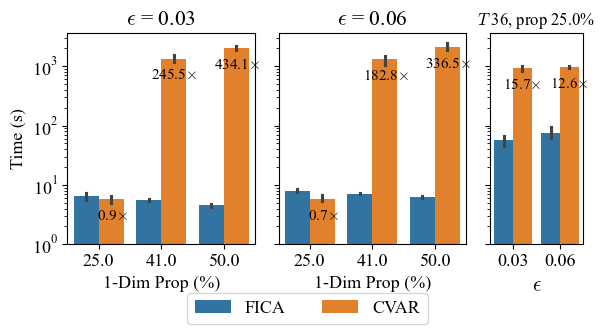

In [11]:
num_seed = 150
seed_threshold = gurobi_seed_list[:num_seed][-1]+1
eps_theta_pair_list_plot = eps_theta_pair_list
N_WDR_list_plot = N_WDR_list
T = 20
onedim_prop_list_plot = res_all_df_onedim_prop['1d_prop'].unique()

import matplotlib.gridspec as gridspec

# Create a figure
fig = plt.figure(figsize=(3*len(eps_theta_pair_list_plot), 3.3))

# Create a grid with 1 row, 3 columns, and specify width ratios
# For example, [1, 1, 0.7] means the third column is 70% as wide as others
gs = gridspec.GridSpec(1, len(eps_theta_pair_list_plot)+1, width_ratios=[1, 1, 0.5])

# Create axes with shared y-axis
axs = []
# Create the first axis
axs.append(plt.subplot(gs[0, 0]))
# Create remaining axes with shared y-axis
for i in range(1, len(eps_theta_pair_list_plot)+1):
    axs.append(plt.subplot(gs[0, i], sharey=axs[0]))


for i, (eps, theta) in enumerate(eps_theta_pair_list_plot):
    res_all_df_plot_onedim_prop = res_all_df_onedim_prop[(res_all_df_onedim_prop['eps'] == eps) & (res_all_df_onedim_prop['theta'] == theta) & (res_all_df_onedim_prop['T'] == T) & (res_all_df_onedim_prop['seed']<=seed_threshold) & (res_all_df_onedim_prop['N_WDR'].isin(N_WDR_list_plot))].copy()
    ax = axs[i]
    ax.set_title(fr'$\epsilon$ = {eps}')
    sns.barplot(x='1d_prop', y='Time', data=res_all_df_plot_onedim_prop, ax=ax, 
         hue='method', estimator='mean', errorbar=('pi', 99))
    for line_i in range(0, len(res_all_df_plot_onedim_prop['N_WDR'].unique())-1):
        ax.axvline(line_i+.5, color='black', linestyle='--')

    # # plot a black horizontal line at timelimit
    # ax.axhline(timelimit, color='black', linestyle='-')
    # set x axis
    ax.set_xlabel('1-Dim Prop (%)')
    ax.set_ylabel('Time (s)')
    # remove y label if i > 0
    if i > 0:
        ax.set_ylabel('')
        # set y_tick labels to white and font 1
        ax.tick_params(axis='y', labelcolor='white', labelsize=1)
    # log y scale
    ax.set_yscale('log')
    # set ylim
    ax.set_ylim(1, timelimit*1.)
    # do not display the legend
    ax.get_legend().remove()
    # calculate the mean time for each method and display the speedup rate (compared to FICA) as text on the plot
    mean_time_FICA = res_all_df_plot_onedim_prop[res_all_df_plot_onedim_prop['method'] == 'FICA']['Time'].groupby(res_all_df_plot_onedim_prop['1d_prop']).mean()
    mean_time_CVAR = res_all_df_plot_onedim_prop[res_all_df_plot_onedim_prop['method'] == 'CVAR']['Time'].groupby(res_all_df_plot_onedim_prop['1d_prop']).mean()
    speedup_rate = mean_time_CVAR / mean_time_FICA
    print(speedup_rate)
    # display the speedup rate in the bar for the barplot of CVAR
    for s_i, speedup_rate_i in enumerate(speedup_rate):
        patch = ax.patches[s_i + len(speedup_rate)]
        ax.text(patch.get_x() + patch.get_width() / 1.9, patch.get_height() * 0.4, f'{speedup_rate_i:.1f}$\\times$', 
                ha='center', va='bottom', fontsize=11, color='black')

# the last plot is to plot the results for T=36, with x being epsilon and hue being method
res_all_df_plot_onedim_prop = res_all_df_onedim_prop[(res_all_df_onedim_prop['T'] == 36) & (res_all_df_onedim_prop['seed']<=seed_threshold) & (res_all_df_onedim_prop['N_WDR'].isin(N_WDR_list_plot))].copy()
ax = axs[-1]
ax.set_title(rf'$T$ 36, prop {res_all_df_onedim_prop["1d_prop"].unique()[0]}%', fontsize=12)
sns.barplot(x='eps', y='Time', data=res_all_df_plot_onedim_prop, ax=ax, 
         hue='method', estimator='mean', errorbar=('pi', 99))
# calculate the mean time for each method and display the speedup rate (compared to FICA) as text on the plot
mean_time_FICA = res_all_df_plot_onedim_prop[res_all_df_plot_onedim_prop['method'] == 'FICA']['Time'].groupby(res_all_df_plot_onedim_prop['eps']).mean()
mean_time_CVAR = res_all_df_plot_onedim_prop[res_all_df_plot_onedim_prop['method'] == 'CVAR']['Time'].groupby(res_all_df_plot_onedim_prop['eps']).mean()
speedup_rate = mean_time_CVAR / mean_time_FICA
# display the speedup rate in the bar for the barplot of CVAR
for s_i, speedup_rate_i in enumerate(speedup_rate):
    patch = ax.patches[s_i + len(speedup_rate)]
    if np.isnan(speedup_rate_i):
        continue
    ax.text(patch.get_x() + patch.get_width() / 2, patch.get_height() * 0.4, f'{speedup_rate_i:.1f}$\\times$', 
                ha='center', va='bottom', fontsize=11, color='black')

ax.set_yscale('log')
# do not display the legend
ax.get_legend().remove()
# remove ylabel
ax.set_ylabel('')
ax.set_xlabel(rf'$\epsilon$', fontsize=15)
ax.tick_params(axis='y', labelcolor='white', labelsize=1)

# create my own legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, .13), ncol=2, )
        #    columnspacing=0.5,  # Reduce space between columns
        #    handletextpad=0.2,  # Reduce space between handle and text
        #    handlelength=.8,)
plt.subplots_adjust(top=0.89, bottom=0.25, left=0.12, right=0.98, hspace=0, wspace=0.15)
# plt.subplots_adjust(top=0.87)
# save the figure
path_name = os.path.join(os.path.dirname(save_path_root), 'figure', f'PD_time_{network_name}_T{T}_onedim_prop.pdf')
if not os.path.exists(os.path.dirname(path_name)):
    os.makedirs(os.path.dirname(path_name))
plt.savefig(path_name)
plt.show()

In [12]:
speedup_rate

eps
0.03    15.662212
0.06    12.614969
Name: Time, dtype: float64

In [13]:
print(ax.patches[0])

Rectangle(xy=(-0.4, 0), width=0.4, height=58.0156, angle=0)


In [14]:
onedim_prop_list_plot

array([25., 41., 50.])

# Compare optimality against exact methods

In [15]:
method_list = ['FICA', 'ExactLHS']
eps_theta_pair_list = [(0.03, 1e-3), (0.06, 1e-3)]
gurobi_seed_list = [i for i in range(0, 10000*10, 10000)] 
num_gen_list = [19]  # the number of thermal generators
N_WDR_list = [40, 80, 120]  # the number of scenarios for the WDRJCC
load_scaling_factor_list = [1, 1.5, 2.0]  # [1] the scaling factor for the load
T_list = [1]

param_comb = list(itertools.product(load_scaling_factor_list, eps_theta_pair_list, T_list, num_gen_list, N_WDR_list))
res_all_df_opt = load_results(param_comb, save_path_root)
# display all rows
pd.set_option('display.max_rows', 10)
res_all_df_opt

,eps,theta,T,load_scaling_factor,num_gen,N_WDR,method,Time,min_cost,reliability,seed,status
0,0.03,0.001,1,1.0,19,40,FICA,0.138287,27100.056184,96.44,0,OPTIMAL
1,0.03,0.001,1,1.0,19,40,ExactLHS,3.895898,27100.056184,96.44,0,OPTIMAL
2,0.03,0.001,1,1.0,19,40,FICA,0.142947,27488.730322,96.50,10000,OPTIMAL
3,0.03,0.001,1,1.0,19,40,ExactLHS,3.115100,27488.730322,96.50,10000,OPTIMAL
4,0.03,0.001,1,1.0,19,40,FICA,0.137597,29432.864328,99.12,20000,OPTIMAL
...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.06,0.001,1,2.0,19,120,ExactLHS,104.198985,64798.321733,84.42,70000,OPTIMAL
356,0.06,0.001,1,2.0,19,120,FICA,0.502383,58337.136197,95.84,80000,OPTIMAL
357,0.06,0.001,1,2.0,19,120,ExactLHS,54.019833,57355.818004,89.50,80000,OPTIMAL
358,0.06,0.001,1,2.0,19,120,FICA,0.491239,37048.140230,94.00,90000,OPTIMAL


In [16]:
res_all_df_opt['status'].unique()

array(['OPTIMAL', 'SUBOPTIMAL', 'INFEASIBLE', 'INF_OR_UNBD', 'NUMERIC'],
      dtype=object)

In [17]:
# calculate the difference in min_cost between FICA and Exact, by matching all other columns
FICA_df = res_all_df_opt[res_all_df_opt['method'] == 'FICA'].copy()
Exact_df = res_all_df_opt[res_all_df_opt['method'] == 'ExactLHS'].copy()
# merge the two dataframes on all columns except 'min_cost'
merged_df = pd.merge(FICA_df, Exact_df, on=['eps', 'theta', 'T', 'load_scaling_factor', 'num_gen', 'N_WDR', 'seed'], suffixes=('_FICA', '_Exact'))
# calculate the difference in min_cost
merged_df['min_cost_diff %'] = (merged_df['min_cost_FICA'] - merged_df['min_cost_Exact']) / merged_df['min_cost_FICA'] * 100  # in percentage
# display the statistics of min_cost_diff % over seeds, for each of the parameter combination
stats_df = merged_df.groupby(['eps', 'theta', 'T', 'num_gen', 'N_WDR', 'load_scaling_factor']).agg({
    'min_cost_diff %': ['mean', 'std', 'min', 'max']
}).reset_index()
stats_df

eps  theta  T num_gen N_WDR load_scaling_factor min_cost_diff %  \
                                                                mean   
0   0.03  0.001  1      19    40                 1.0       -0.005564   
1   0.03  0.001  1      19    40                 1.5        0.032182   
2   0.03  0.001  1      19    40                 2.0        0.146186   
3   0.03  0.001  1      19    80                 1.0        0.004690   
4   0.03  0.001  1      19    80                 1.5        0.095268   
..   ...    ... ..     ...   ...                 ...             ...   
13  0.06  0.001  1      19    80                 1.5        0.169463   
14  0.06  0.001  1      19    80                 2.0        0.663787   
15  0.06  0.001  1      19   120                 1.0        0.041246   
16  0.06  0.001  1      19   120                 1.5        0.186544   
17  0.06  0.001  1      19   120                 2.0        0.583067   

                                          
         std           min           max  
0   0.017595 -5.564037e-02  2.338255e-09  
1   0.115357 -9.137141e-02  2.861752e-01  
2   0.267684 -4.227841e-02  7.031876e-01  
3   0.035271 -5.564037e-02  6.303281e-02  
4   0.139693 -6.721558e-02  3.967742e-01  
..       ...           ...           ...  
13  0.230164 -4.524822e-02  6.106907e-01  
14  0.789678 -2.986143e-02  2.447220e+00  
15  0.046647 -7.331427e-03  1.139619e-01  
16  0.226707 -1.084025e-03  5.830409e-01  
17  0.551445  2.731812e-11  1.682150e+00  

[18 rows x 10 columns]

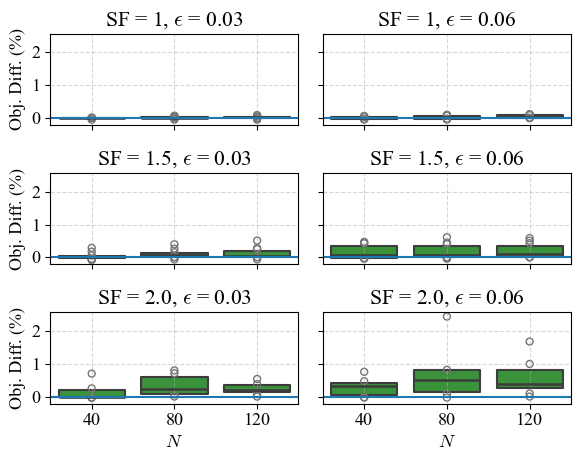

In [21]:
# plot the results
# the second color of tab:10
T = 1
num_gen = 19
color = sns.color_palette("tab10")[2]
eps_theta_pair_list_plot = eps_theta_pair_list
N_WDR_list_plot = N_WDR_list
fig, axs = plt.subplots(len(load_scaling_factor_list), len(eps_theta_pair_list_plot), 
                        figsize=(3*len(eps_theta_pair_list_plot), 1.6 * len(load_scaling_factor_list)), sharex=True, sharey=True)
# Plot each subplot
for i, load_scaling_factor in enumerate(load_scaling_factor_list):
    for j, (eps, theta) in enumerate(eps_theta_pair_list_plot):
        # Filter and prepare the data
        res_all_df_plot_opt = merged_df[(merged_df['eps'] == eps) & 
                                    (merged_df['theta'] == theta) & 
                                    (merged_df['num_gen'] == num_gen) & 
                                    (merged_df['seed']<=seed_threshold) & 
                                    (merged_df['T'] == T) & 
                                    (merged_df['N_WDR'].isin(N_WDR_list_plot)) &
                                    (merged_df['load_scaling_factor'] == load_scaling_factor)].copy()

        ax = axs[i, j]

        # Strip plot: showing the distribution of data points
        # sns.stripplot(x='N_WDR', y='min_cost_diff %', data=res_all_df_plot_opt, ax=ax, dodge=True, legend=False, marker='o', alpha=0.7, color=color, jitter=True)
        sns.boxenplot(x='N_WDR', y='min_cost_diff %', data=res_all_df_plot_opt, ax=ax, 
                    order=N_WDR_list_plot, color=color, linewidth=1.5, showfliers=True)
        
        # make a horizontal line at 0
        ax.axhline(0, color=sns.color_palette("tab10")[0], linestyle='-')
        # Set the title for the subplot
        ax.set_title(fr'SF = {load_scaling_factor}, $\epsilon$ = {eps}')
        # set yticks to 0, 1, 2
        ax.set_yticks([0, 1, 2])

        # Set x-axis label
        ax.set_xlabel('$N$')
        ax.set_ylabel('Obj. Diff. (%)')
        ax.grid(True, linestyle='--', alpha=0.5)
    
        
plt.tight_layout()
# plt.subplots_adjust(top=0.87)
# save the figure
path_name = os.path.join(os.path.dirname(save_path_root), 'figure', f'PD_optgap_{network_name}_T{T}.pdf')
if not os.path.exists(os.path.dirname(path_name)):
    os.makedirs(os.path.dirname(path_name))
plt.savefig(path_name)